In [1]:
import os
import cv2
import json
import numpy as np
import pickle
import csv
import re
import pandas as pd
import matplotlib.patches as patches
import torch as T

from matplotlib import pyplot as plt
from time import sleep

%matplotlib inline

---

# WIDER Face

In [2]:
from motion_capture.data.datasets import WIDERFaceDataset

number_of_faces = 10
image_shape = (448, 448)
wider_face_dataset = WIDERFaceDataset(
    output_image_shape=image_shape, 
    max_number_of_faces=number_of_faces,
    train_path="//192.168.2.206/data/datasets/WIDER-Face/train",
    val_path="//192.168.2.206/data/datasets/WIDER-Face/val",
    center_bbox=True)

test_i = 11


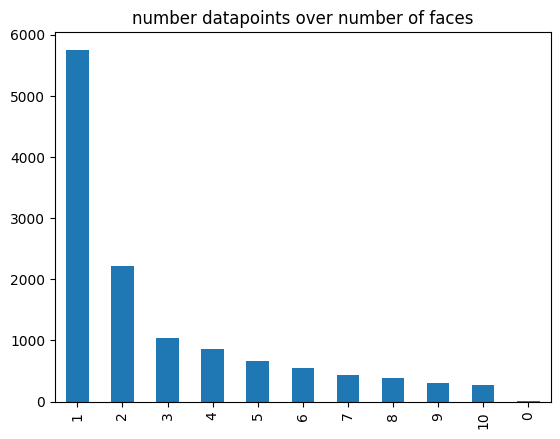

In [3]:
face_counts = pd.Series([anot_dp["numberOfFaces"] for anot_dp in wider_face_dataset.annotation_datapoints]).value_counts()
face_counts[:20].plot.bar()
plt.title("number datapoints over number of faces")
plt.show()

number of faces 1


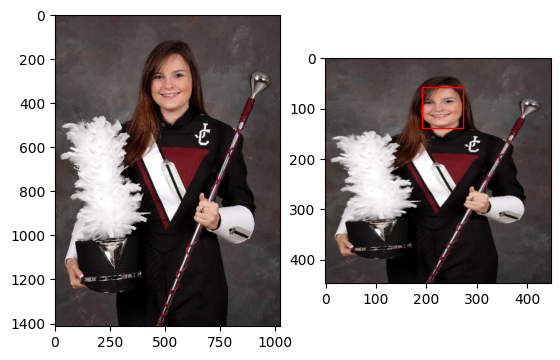

In [4]:
original_image = cv2.cvtColor(cv2.imread(wider_face_dataset.annotation_datapoints[test_i]["imagePath"]), cv2.COLOR_BGR2RGB)
_, ax = plt.subplots(1, 2)

# plot original image
ax[0].imshow(original_image)

# plot image with bounding boxes
print(f"number of faces {wider_face_dataset.annotation_datapoints[test_i]['numberOfFaces']}")
test_image = wider_face_dataset[test_i]["image"].permute(1, 2, 0).round().byte().numpy()
faces = wider_face_dataset[test_i]["faceBbox"]
ax[1].imshow(test_image)

for i in range(faces.shape[0]):
    x, y, w, h = faces[i]
    ax[1].add_patch(
        patches.Rectangle(
            (x-w, y-h), 
            w*2, h*2, 
            linewidth=1, 
            edgecolor="red", 
            facecolor="none"))

# plt.show()

---

# WFLW

In [5]:
from motion_capture.data.datasets import WFLWDataset

wflw_dataset = WFLWDataset(
    output_full_image_shape=(448, 448),
    output_face_image_shape=(112, 112),
    center_bbox=True,
    image_path="//192.168.2.206/data/datasets/WFLW/images",
    annotation_path="//192.168.2.206/data/datasets/WFLW/annotations")

test_i = 2

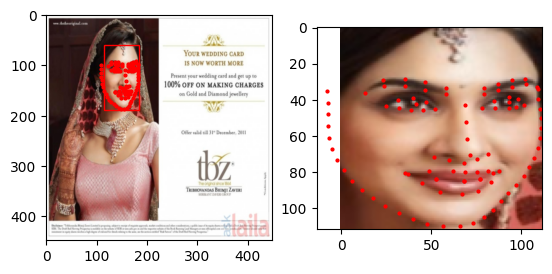

In [6]:
test_full_image = wflw_dataset[test_i]["fullImage"].permute(1, 2, 0).round().byte().numpy()
test_face_image = wflw_dataset[test_i]["faceImage"].permute(1, 2, 0).round().byte().numpy()

_, ax = plt.subplots(1, 2)

# plot full image, bounding box and keypoints
ax[0].imshow(test_full_image)

x, y, w, h = wflw_dataset[test_i]["faceBbox"]
ax[0].add_patch(
    patches.Rectangle(
        (x-w, y-h), 
        w*2, h*2, 
        linewidth=1, 
        edgecolor="red", 
        facecolor="none"))

for dp in wflw_dataset[test_i]["globalKeypoints"]:
    ax[0].plot(dp[0], dp[1], "ro", markersize=2)

# plot face image and keypoints
ax[1].imshow(test_face_image)

for dp in wflw_dataset[test_i]["localKeypoints"]:
    ax[1].plot(dp[0], dp[1], "ro", markersize=2)


plt.show()

# COFW

In [7]:
from motion_capture.data.datasets import COFWColorDataset

cofw_color_dataset = COFWColorDataset(
    output_full_image_shape=(448, 448),
    output_face_image_shape=(112, 112),
    data_path="//192.168.2.206/data/datasets/COFW/")

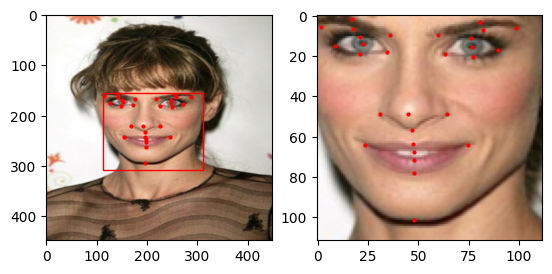

In [8]:
test_i = 1

test_full_image = cofw_color_dataset[test_i]["fullImage"].permute(1, 2, 0).round().byte().numpy()
test_face_image = cofw_color_dataset[test_i]["faceImage"].permute(1, 2, 0).round().byte().numpy()

_, ax = plt.subplots(1, 2)

# plot full image, bounding box and keypoints
ax[0].imshow(test_full_image)

x, y, w, h = cofw_color_dataset[test_i]["faceBbox"]
ax[0].add_patch(
    patches.Rectangle(
        (x-w, y-h), 
        w*2, h*2, 
        linewidth=1, 
        edgecolor="red", 
        facecolor="none"))

for dp in cofw_color_dataset[test_i]["globalKeypoints"]:
    ax[0].plot(dp[0], dp[1], "ro", markersize=2)

# plot face image and keypoints
ax[1].imshow(test_face_image)

kpts = cofw_color_dataset[test_i]["localKeypoints"]
for i in range(kpts.shape[0]):
    if cofw_color_dataset[test_i]["keypointOcclusion"][i] == 1:
        ax[1].plot(kpts[i][0], kpts[i][1], "bo", markersize=2)
    else:
        ax[1].plot(kpts[i][0], kpts[i][1], "ro", markersize=2)

plt.show()

# MPII

In [2]:
from motion_capture.data.datasets import MPIIDataset

mpii_dataset = MPIIDataset(
    output_full_image_shape=(448, 448),
    output_person_image_shape=(112, 112),
    annotation_path="//192.168.2.206/data/datasets/MPII/annotations",
    image_folder_path="//192.168.2.206/data/datasets/MPII/images"
)


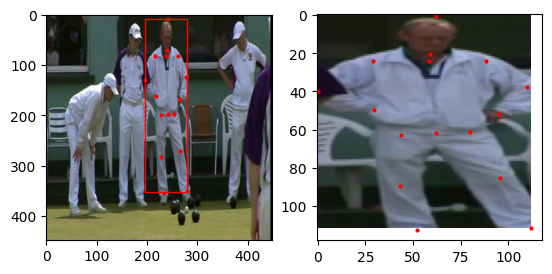

In [4]:
test_i = 110


_, ax = plt.subplots(1, 2)

# plot full image, keypoints, center and bounding box
ax[0].imshow(mpii_dataset[test_i]["fullImage"].permute(1,2,0).byte().numpy())

for dp in mpii_dataset[test_i]["globalKeypoints"]:
    ax[0].plot(dp[0], dp[1], "ro", markersize=2)

x, y, w, h = mpii_dataset[test_i]["bbox"]
ax[0].add_patch(
    patches.Rectangle(
        (x-w, y-h), 
        w*2, h*2, 
        linewidth=1, 
        edgecolor="red", 
        facecolor="none"))

# plot person image and keypoints
ax[1].imshow(mpii_dataset[test_i]["personImage"].permute(1,2,0).byte().numpy())

for dp in mpii_dataset[test_i]["localKeypoints"]:
    ax[1].plot(dp[0], dp[1], "ro", markersize=2)

plt.show()

# FDDB

## TODO (but looks kinda tedious)

# HAKE Large

In [38]:
annotations = json.load(open("\\\\NAS\\Data\\datasets\\HAKE\\Annotations\\hake_large_annotation.json", "r"))
annotations = pd.DataFrame.from_records(annotations).T

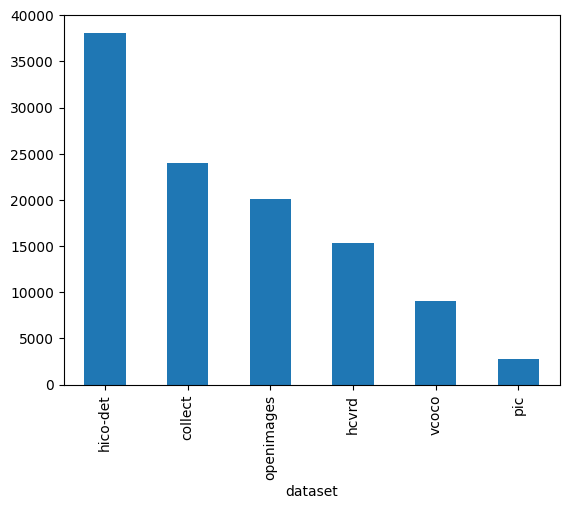

In [53]:
annotations["dataset"].value_counts().plot(kind="bar")
plt.show()

In [83]:
for ds in annotations["dataset"].unique():
    labels = annotations[annotations["dataset"] == ds]["labels"]

labels.apply(lambda a: [len(aa["action_labels"]) for aa in a])

indoor_00003.jpg                                               [1, 1]
indoor_00004.jpg                                   [2, 1, 1, 1, 1, 1]
indoor_00006.jpg                                               [1, 1]
indoor_00007.jpg     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1]
indoor_00018.jpg                                               [2, 1]
                                           ...                       
outdoor_06671.jpg                      [5, 3, 5, 3, 2, 1, 1, 1, 5, 3]
outdoor_06672.jpg                            [1, 1, 1, 1, 1, 1, 2, 1]
outdoor_06673.jpg                [3, 3, 4, 4, 2, 2, 2, 2, 1, 1, 3, 3]
outdoor_06674.jpg                      [1, 1, 2, 1, 2, 1, 1, 2, 1, 2]
outdoor_06693.jpg                                                 [1]
Name: labels, Length: 2736, dtype: object

# hico_det

In [ ]:
# hd = scipy.io.loadmat("./../_data/_usefull/_images/Halpe-FullBody/hico_det/anno.mat")
# hd_bb = scipy.io.loadmat("./../_data/_usefull/_images/Halpe-FullBody/hico_det/anno_bbox.mat")

# """

# len(hd_bb["bbox_train"][0][i][1][0]) = 1

# len(hd_bb["bbox_train"][0][i][0]) = 1
# (name)


# """

In [ ]:
# hd_bb.keys()

In [ ]:
# print(len(hd["list_train"]), len(hd["list_test"]))

# hd_bb["bbox_train"][0][0][0]
# hd_bb["bbox_train"][0][0][1]

# for i in range(len(hd_bb["bbox_train"][0])):
#     image_name = hd_bb["bbox_train"][0][i][0][0]

#     width, height, depth = hd_bb["bbox_train"][0][i][1][0][0]
#     width, height, depth = width[0][0], height[0][0], depth[0][0]


# sum([len(hd_bb["bbox_train"][0][i][2][0]) for i in range(len(hd_bb["bbox_train"][0]))])

# [b[1] for b in hd_bb["bbox_train"][0][0][2][0]]




# RHDv2

In [ ]:
# arr = pickle.load(open("./../_data/_usefull/_images/RHD_published_v2/training/anno_training.pickle", "br"))

"""

arr[i]["xyz"] = xyz keypoints
arr[i]["uv_vis] = uv + visibility
arr[i]["K"] = camera
(i == image)


"""
None

# HAKE

In [ ]:
# hake_large_annotation = json.load(open("./../_data/_usefull/_images/HAKE/Annotations/hake_large_annotation.json", "r"))
# hico_det_training_set_instance_level = json.load(open("./../_data/_usefull/_images/HAKE/Annotations/hico-det-training-set-instance-level.json", "r"))
# hico_training_set_image_level = json.load(open("./../_data/_usefull/_images/HAKE/Annotations/hico-training-set-image-level.json", "r"))

"""

hico training set image level

{'arm_list': [0, 0, 0, 0, 1], 
'foot_list': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
'hand_list': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
'head_list': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 
'hip_list': [1, 0, 0, 0, 0], 
'hoi_id': [153, 154, 155, 156], 
'leg_list': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0], 
'parts_list': [1, 1, 1, 1, 1, 0, 1, 0, 0, 1]}


hico det training set instance level

{'dataset': 'hico-det', 
'labels': [
    {
        'action_labels': 
            [{'human_part': 6, 'partstate': 0}, 
            {'human_part': 9, 'partstate': 0}, 
            {'human_part': 4, 'partstate': 0}, 
            {'human_part': 0, 'partstate': 0}, 
            {'human_part': 3, 'partstate': 0}], 
        'height': 480, 
        'hoi_id': 153, 
        'human_bbox': [208, 33, 427, 300], 
        'object_bbox': [59, 98, 572, 405], 
        'width': 640
    }, 
    {
        'action_labels': 
            [{'human_part': 4, 'partstate': 0}, 
            {'human_part': 1, 'partstate': 6}, 
            {'human_part': 2, 'partstate': 6}], 
        'height': 480, 
        'hoi_id': 156, 
        'human_bbox': [209, 26, 444, 317], 
        'object_bbox': [59, 99, 579, 395], 
        'width': 640
    },
        ...], 
'path_prefix': 'hico_20160224_det/images/train2015'}



hake large annotation

{'dataset': 'hico-det', 
'labels': [
    {'action_labels': 
        [{'human_part': 6, 'partstate': 0}, {'human_part': 9, 'partstate': 0}, {'human_part': 4, 'partstate': 0}, {'human_part': 0, 'partstate': 0}, {'human_part': 3, 'partstate': 0}], 'height': 480, 'hoi_id': 153, 'human_bbox': [208, 33, 427, 300], 'object_bbox': [59, 98, 572, 405], 'width': 640}, 
    {'action_labels': 
        [{'human_part': 4, 'partstate': 0}, {'human_part': 1, 'partstate': 6}, {'human_part': 2, 'partstate': 6}], 'height': 480, 'hoi_id': 156, 'human_bbox': [209, 26, 444, 317], 'object_bbox': [59, 99, 579, 395], 'width': 640}, 
    {'action_labels': 
        [{'human_part': 6, 'partstate': 0}, {'human_part': 9, 'partstate': 0}, {'human_part': 4, 'partstate': 0}, {'human_part': 0, 'partstate': 0}, {'human_part': 3, 'partstate': 0}], 'height': 480, 'hoi_id': 154, 'human_bbox': [213, 20, 438, 357], 'object_bbox': [77, 115, 583, 396], 'width': 640}, {'action_labels': [{'human_part': 4, 'partstate': 0}], 'height': 480, 'hoi_id': 155, 'human_bbox': [206, 33, 427, 306], 'object_bbox': [61, 100, 571, 401], 'width': 640}], 
    ...
    
'path_prefix': 'hico_20160224_det/images/train2015'}


"""
None

# FreiHAND

In [ ]:
"""
training_K = json.load(open("./../_data/_usefull/FreiHAND/FreiHAND_pub_v2/training_K.json", "r"))
training_mano = json.load(open("./../_data/_usefull/FreiHAND/FreiHAND_pub_v2/training_mano.json", "r"))
training_scale = json.load(open("./../_data/_usefull/FreiHAND/FreiHAND_pub_v2/training_scale.json", "r"))
training_verts = json.load(open("./../_data/_usefull/FreiHAND/FreiHAND_pub_v2/training_verts.json", "r"))
training_xyz = json.load(open("./../_data/_usefull/FreiHAND/FreiHAND_pub_v2/training_xyz.json", "r"))

# length is the same for all = 32560 = number of greenscreened images

K = intrinsic camera matrix
mano = mano annotations ?
verts = 3d vertecies
xyz = 3d shape
"""

# Kinect

In [ ]:
# info = json.load(open("./../_data/_usefull/KinectDatasets/data/training/info.json", "r"))
# calib = json.load(open("./../_data/_usefull/KinectDatasets/data/training/calib.json", "r"))
# anno = json.load(open("./../_data/_usefull/KinectDatasets/data/training/anno.json", "r"))
# pred_sdk = json.load(open("./../_data/_usefull/KinectDatasets/data/training/pred_sdk.json", "r"))

# captury_info = json.load(open("./../_data/_usefull/KinectDatasets/data/captury_train/info.json", "r"))
# captury_calib = json.load(open("./../_data/_usefull/KinectDatasets/data/captury_train/calib.json", "r"))
# captury_anno = json.load(open("./../_data/_usefull/KinectDatasets/data/captury_train/anno.json", "r"))
# captury_pred_sdk = json.load(open("./../_data/_usefull/KinectDatasets/data/captury_train/pred_sdk.json", "r"))
# captury_pred_sdk_cap = json.load(open("./../_data/_usefull/KinectDatasets/data/captury_train/pred_sdk_cap.json", "r"))

"""
1920x1080

anno[0][0] = 18 kpts + vis

pred_sdk[0][i] = 25 kpts + vis (is a prediction)
(i == 4 for all)


captury_pred_sdk[0][i] = 25 kpts + vis
(i == 1 for all)

captury_pred_sdk_cap[0][i] = 25 kpts + vis
(i == 2 for all)


"""
None